# Hyperparameters tuning (Estimators of the NRDD and its transforms)

In [71]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import NuSVR
from lightgbm import LGBMRegressor

In [72]:
# Load dataframes from binary files
fam = '03'
#base_dir = r'C:\FBr\Weiterbildung\Project'
base_dir = r'D:\Entwicklungen\share\DataScienceProject'

all_data = {}
fam_dir = os.path.join(base_dir, fam, 'data-' + fam)
all_data[fam] = {}

ft_param_path = os.path.join(base_dir, 'Scripts', 'ft_files', str(fam) + '-feat-parameters.ft')
df_params = pd.read_feather(ft_param_path)

ft_pca_path = os.path.join(base_dir, 'Scripts', 'ft_files', str(fam) + '-pca-long-displacements.ft')
df_disp_pca = pd.read_feather(ft_pca_path)

In [73]:
df_params.head()

,dp_no,dim_x,dim_y,dim_z,nb_slots_x,slot_x_length,slot_x_distance,nb_slots_z,slot_z_length,slot_z_distance,...,disp_long_396,disp_long_397,disp_long_398,disp_long_399,sum_sensi,coupling_long,slot_2-2,slot_3-2,slot_4-1,slot_4-2
0,1001,175.06,121.95,240.31,4,75.993,43.235,2,78.219,59.508,...,0.170716,0.140101,0.144549,0.151599,3.405414e-16,0.960466,0,0,0,1
1,1002,173.45,122.77,238.13,4,81.168,45.859,2,78.924,57.208,...,0.167263,0.146107,0.139493,0.143682,5.401730e-17,0.956635,0,0,0,1
2,1003,175.85,116.71,238.10,4,77.532,45.260,2,80.099,49.215,...,0.293034,0.274524,0.277739,0.284010,2.678586e-18,0.986845,0,0,0,1
3,1004,173.51,116.37,238.30,4,82.428,51.007,2,74.757,50.840,...,0.242726,0.182347,0.183003,0.186770,8.933099e-18,0.967459,0,0,0,1
4,1005,175.60,118.72,241.04,4,76.576,45.981,2,78.773,64.702,...,0.260120,0.259677,0.281911,0.293833,8.025438e-18,0.991598,0,0,0,1


The columns of the DataFrame df_params are listed in the text file df_params_cols.txt

In [74]:
lst_param = df_params.columns.to_list()

# Preparation of the variables

Definition of the explanatory variables (geometrical parameters)

In [75]:
# Unscaled explanatory variables
lst_slot_class = lst_param[541:545]
lst_expl = lst_param[1:4] + lst_param[5:7] + lst_param[8:24] + lst_param[32:34]
X = df_params[lst_expl + lst_slot_class]

# Prediction of the Normalized Relative Displacement Deviation of the output displacement

The MLP estimator had the best scores during the benchmark and the cross-validation. In this notebook we will tune their hyperparameters with a Bayesian approach to optimize the precisions.

In [76]:
# Target variable: NRDD
target = 'long_disp_nrdd'
y = df_params[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=55)

### Hyperparameters tuning

Pipeline with the MLPRegressor

In [39]:
preprocessor = ColumnTransformer(
                            transformers=[
                                        ('numerical', StandardScaler(), lst_expl),
                                        ('categorical', 'passthrough', lst_slot_class)]
                                    )

start_mlp = MLPRegressor(max_iter=400, random_state=55)

pipe_start_mlp = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('regressor', start_mlp)
                        ])

In [40]:
# Start model
pipe_start_mlp.fit(X_train, y_train)
y_pred_start_mlp = pipe_start_mlp.predict(X_test)

c:\Users\fbrouet\.conda\envs\fbr\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


In [41]:
preprocessor = ColumnTransformer(transformers=[
                                    ('numerical', StandardScaler(), lst_expl),
                                    ('categorical', 'passthrough', lst_slot_class)]
                                )

pipe_tuned_mlp = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('mlpregressor', start_mlp)
                ])

params_mlp = {'mlpregressor__hidden_layer_sizes': Integer(80, 500),
                'mlpregressor__activation': Categorical(['identity', 'logistic', 'tanh', 'relu']),
                'mlpregressor__solver': Categorical(['lbfgs', 'sgd', 'adam']),
                'mlpregressor__alpha': Real(1e-5, 1e-1, prior='log-uniform'),
                'mlpregressor__batch_size': Integer(100, 300),
                'mlpregressor__learning_rate': Categorical(['constant', 'invscaling', 'adaptive']),
                'mlpregressor__learning_rate_init': Real(1e-4, 1e-2, prior='log-uniform')
              }

bayes_search = BayesSearchCV(estimator=pipe_tuned_mlp,
                             search_spaces=params_mlp,
                             n_iter=32,
                             scoring='r2',
                             random_state=55,
                             cv=KFold(n_splits=5, shuffle=True, random_state=55),
                             verbose=True,
                             refit=True,
                             n_jobs=-1)

In [42]:
# Perform the bayesian search
bayes_search.fit(X_train, y_train)
print ('Best score:', bayes_search.best_score_)
print ('Best parameters_', bayes_search.best_params_)
print ('Score of the test set:', bayes_search.score(X_test, y_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\fbrouet\.conda\envs\fbr\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


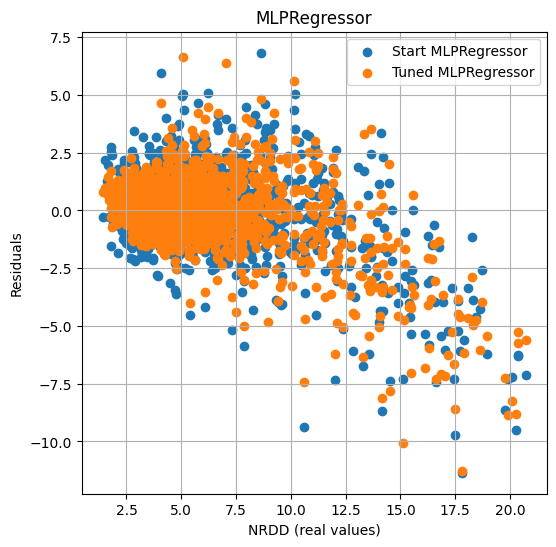

In [43]:
y_pred_tuned_mlp = bayes_search.predict(X_test)

fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_start_mlp-y_test, label='Start MLPRegressor')
plt.scatter(y_test, y_pred_tuned_mlp-y_test, label='Tuned MLPRegressor')
plt.xlabel('NRDD (real values)')
plt.ylabel('Residuals')
plt.grid(True)
plt.title('MLPRegressor')
plt.legend()
plt.grid(True)
plt.show()

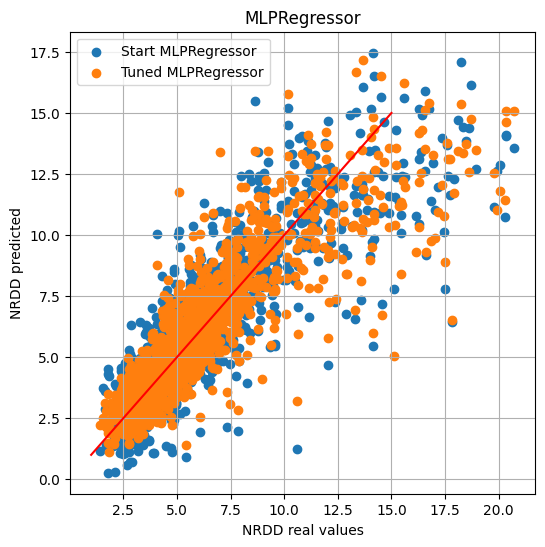

In [77]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_start_mlp, label='Start MLPRegressor')
plt.scatter(y_test, y_pred_tuned_mlp, label='Tuned MLPRegressor')
plt.plot([1, 15], [1, 15], 'r')
plt.xlabel('NRDD real values')
plt.ylabel('NRDD predicted')
plt.title('MLPRegressor')
plt.legend()
plt.grid(True)
plt.show()

# Prediction of the inverse of the NRDD

In this notebook we will tune the hyperparameters of the LightGBM model, which is training with the inverse of the NRDD as target variable.

In [58]:
# Target variable: 1/NRDD
target = 'long_disp_nrdd'
y = 1/df_params[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=55)

### Hyperparameter tuning of the LightGBM model

In [59]:
preprocessor = ColumnTransformer(transformers=[
                                    ('numerical', StandardScaler(), lst_expl),
                                    ('categorical', 'passthrough', lst_slot_class)]
                                )

start_lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.1, force_col_wise=True)

pipe_start_lgbm = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('regressor', start_lgbm)
                ])

In [60]:
# Start model
pipe_start_lgbm.fit(X_train, y_train)
y_pred_start_lgbm = pipe_start_lgbm.predict(X_test)

[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 0.211296


In [62]:
preprocessor = ColumnTransformer(transformers=[
                                    ('numerical', StandardScaler(), lst_expl),
                                    ('categorical', 'passthrough', lst_slot_class)]
                                )

pipe_tuned_lgbm = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('regressor', start_lgbm)
                ])

params_lgbm = {'regressor__n_estimators': Integer(100, 15000),
                'regressor__num_leaves': Integer(4, 8),
                'regressor__min_child_samples': Integer(5, 20),
                'regressor__learning_rate': Real(1e-3, 1e0, prior='log-uniform'),
                'regressor__reg_alpha': Real(1e-5, 1e0, prior='log-uniform'),
                'regressor__reg_lambda': Real(1e-5, 1e0, prior='log-uniform')}

bayes_search = BayesSearchCV(estimator=pipe_tuned_lgbm,
                             search_spaces=params_lgbm,
                             n_iter=256,
                             scoring='r2',
                             random_state=55,
                             cv=KFold(n_splits=5, shuffle=True, random_state=55),
                             verbose=True,
                             refit=True,
                             n_jobs=-1)

# Perform the bayesian search
bayes_search.fit(X_train, y_train)
print ('Best score:', bayes_search.best_score_)
print ('Best parameters_', bayes_search.best_params_)
print ('Score of the test set:', bayes_search.score(X_test, y_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

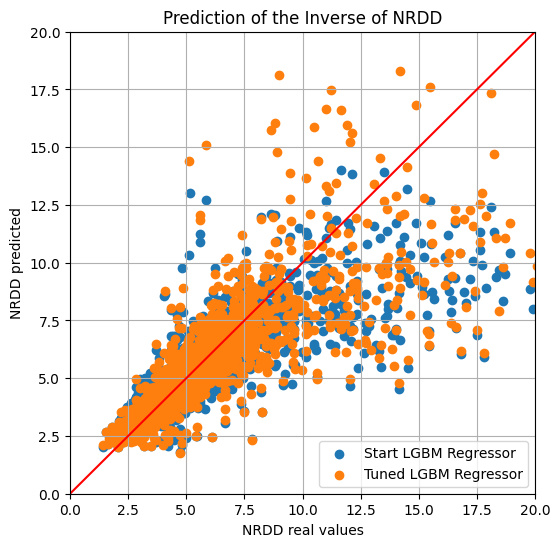

In [64]:
y_pred_start_lgbm = pipe_start_lgbm.predict(X_test)
y_pred_tuned_lgbm = bayes_search.predict(X_test)

fig = plt.figure(figsize=(6, 6))
plt.scatter(1/y_test, 1/y_pred_start_lgbm, label='Start LGBM Regressor')
plt.scatter(1/y_test, 1/y_pred_tuned_lgbm, label='Tuned LGBM Regressor')
plt.plot([0, 20], [0, 20], 'r')
plt.xlabel('NRDD real values')
plt.ylabel('NRDD predicted')
plt.legend()
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.grid(True)
plt.title('Prediction of the Inverse of NRDD')
plt.show()

### Conclusion

The hyperparameter tuning of the LightGBM improved the mean score. However some points are move diverging with the tuned model.

# Prediction of the transformed NRDD with QuantileTransformer

In [65]:
# Target variable
target = 'long_disp_nrdd'
y = df_params[[target]]

In [66]:
preprocessor = ColumnTransformer(transformers=[
                                    ('numerical', StandardScaler(), lst_expl),
                                    ('categorical', 'passthrough', lst_slot_class)]
                                )

start_lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.1, force_col_wise=True)

pipe_start_lgbm = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('regressor', start_lgbm)
                ])

transf = QuantileTransformer()
w = transf.fit_transform(y)

X_train, X_test, w_train, w_test = train_test_split(X, w, test_size = 0.2, random_state=55)

# Start model
pipe_start_lgbm.fit(X_train, w_train)
w_pred_start_lgbm = pipe_start_lgbm.predict(X_test)

[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 0.500763


c:\Users\fbrouet\.conda\envs\fbr\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [52]:
preprocessor = ColumnTransformer(transformers=[
                                    ('numerical', StandardScaler(), lst_expl),
                                    ('categorical', 'passthrough', lst_slot_class)]
                                )

pipe_tuned_lgbm = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('regressor', start_lgbm)
                ])

params_lgbm = {'regressor__n_estimators': Integer(100, 15000),
                'regressor__num_leaves': Integer(4, 15),
                'regressor__min_child_samples': Integer(2, 8),
                'regressor__learning_rate': Real(1e-3, 1e0, prior='log-uniform'),
                'regressor__reg_alpha': Real(1e-3, 1e2, prior='log-uniform'),
                'regressor__reg_lambda': Real(1e-7, 1e-1, prior='log-uniform')}

bayes_search = BayesSearchCV(estimator=pipe_tuned_lgbm,
                             search_spaces=params_lgbm,
                             n_iter=64,
                             scoring='r2',
                             random_state=55,
                             cv=KFold(n_splits=5, shuffle=True, random_state=55),
                             verbose=True,
                             refit=True,
                             n_jobs=-1)

# Perform the bayesian search
bayes_search.fit(X_train, w_train)
print ('Best score:', bayes_search.best_score_)
print ('Best parameters_', bayes_search.best_params_)
print ('Score of the test set:', bayes_search.score(X_test, w_test))

w_pred_start_lgbm = pipe_start_lgbm.predict(X_test)
w_pred_tuned_lgbm = bayes_search.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\fbrouet\.conda\envs\fbr\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 0.500763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

c:\Users\fbrouet\.conda\envs\fbr\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
c:\Users\fbrouet\.conda\envs\fbr\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
c:\Users\fbrouet\.conda\envs\fbr\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


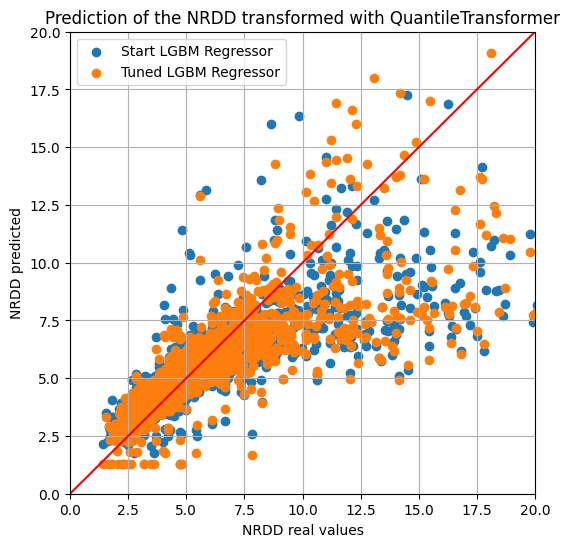

In [70]:
y_test = transf.inverse_transform(w_test)
y_pred_start_lgbm = transf.inverse_transform(pd.DataFrame(w_pred_start_lgbm))
y_pred_tuned_lgbm = transf.inverse_transform(pd.DataFrame(w_pred_tuned_lgbm))

fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_start_lgbm, label='Start LGBM Regressor')
plt.scatter(y_test, y_pred_tuned_lgbm, label='Tuned LGBM Regressor')
plt.xlabel('NRDD real values')
plt.ylabel('NRDD predicted')
plt.legend()
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.plot([0, 20], [0, 20], 'r')
plt.grid(True)
plt.title('Prediction of the NRDD transformed with QuantileTransformer')
plt.show()